<a href="https://colab.research.google.com/github/akiecodes/Crime-And-Anomaly-Detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import zipfile
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LSTM, GlobalAveragePooling2D, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with zipfile.ZipFile('anomaly_detection.zip', 'r') as zip_ref:
    zip_ref.extractall('sample_data')

# Hyperparameters

In [ ]:
train_dir = "/content/sample_data/Train"
test_dir = "/content/sample_data/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
SEQUENCE_LENGTH = 10
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

# Data Pre-Processing

In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

# Defining Generators

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 8987 images belonging to 14 classes.
Found 10946 images belonging to 14 classes.


# Train Data Distribution

In [ ]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# Test Data Distribution

In [ ]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# 1. **DenseNet121 Model**

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model1 = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model1.compile(optimizer=tf.keras.optimizers.SGD(LR),
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

    return model1

model1 = define_compile_model()
clear_output()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

In [ ]:
history = model1.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

141/141 [==============================] - 110s 318ms/step - loss: 3.1273 - auc: 0.5306 - val_loss: 3.3990 - val_auc: 0.4450


# AUC Curve

172/172 [==============================] - 11s 54ms/step
ROC AUC score: 0.44762327903249605


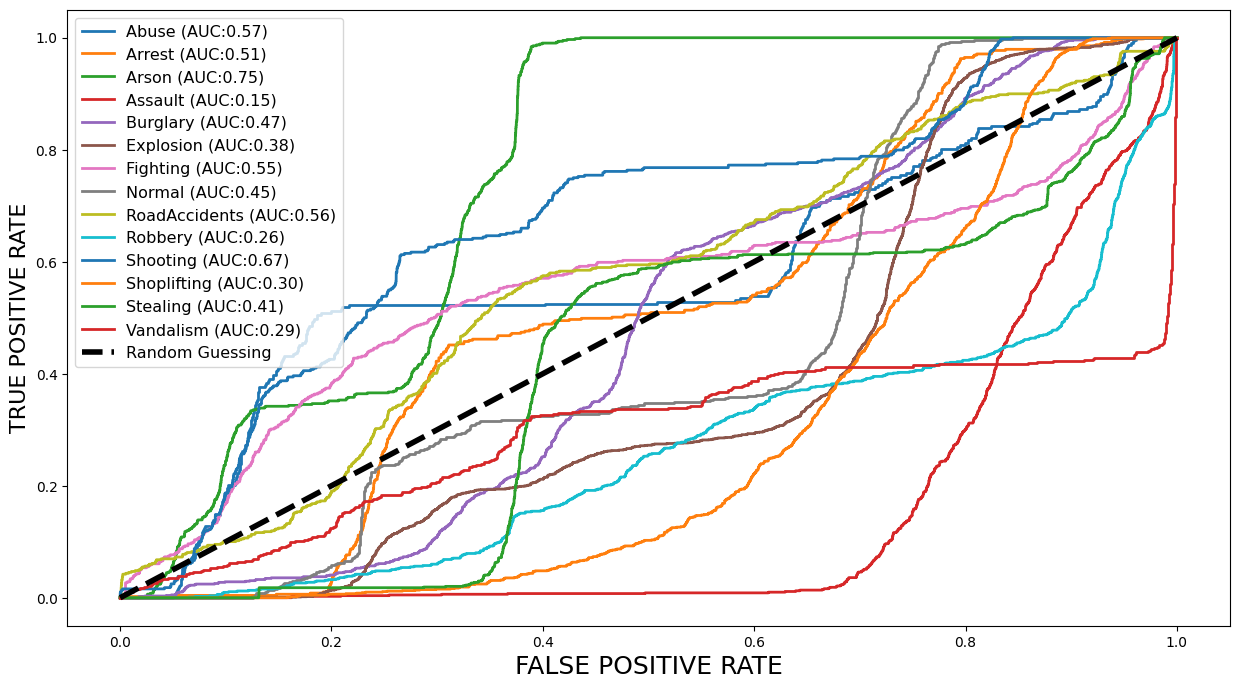

In [ ]:
preds = model1.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

# 2. **VGG-19 Model**

In [ ]:
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Building our own classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.AUC()]
)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

140/140 [==============================] - 48s 269ms/step - loss: 2.5131 - auc_1: 0.6490 - val_loss: 2.8203 - val_auc_1: 0.5193


172/172 [==============================] - 10s 56ms/step
ROC AUC score: 0.5123833384752708


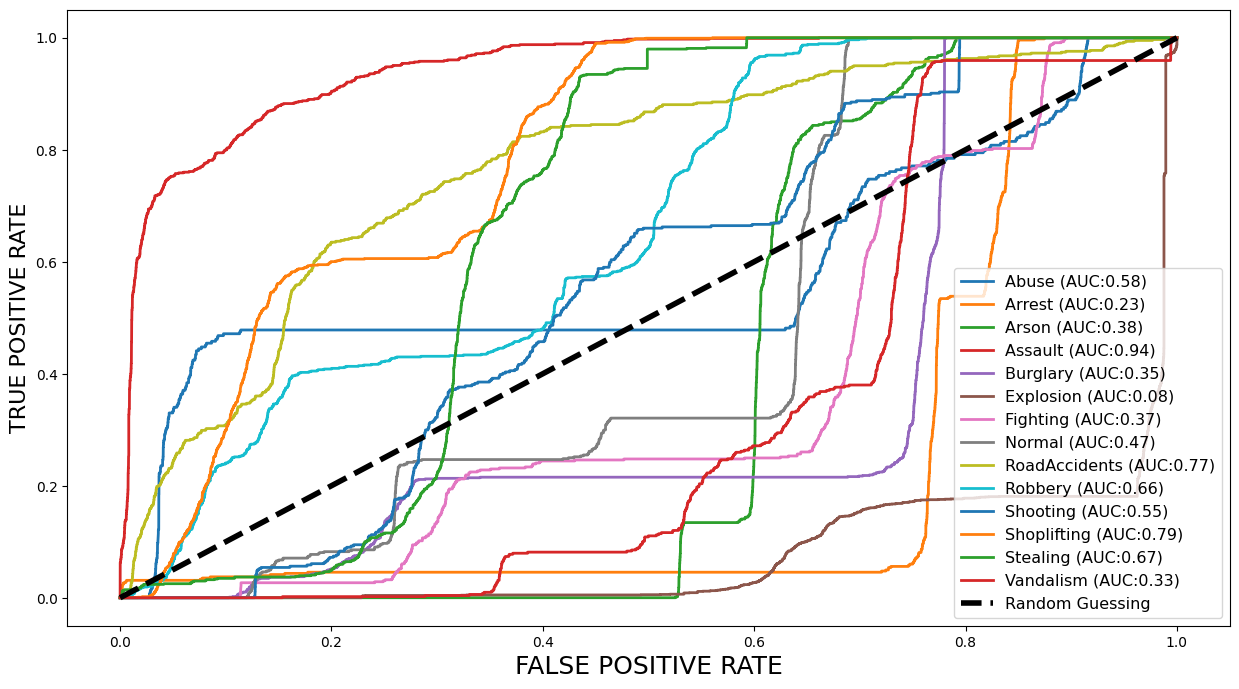

In [ ]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    roc_auc = roc_auc_score(y_test, y_pred, average='macro')
    return roc_auc

roc_auc = multiclass_roc_auc_score(y_test, preds)
print('ROC AUC score:', roc_auc)
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

# 3. **ResNet50 Model**

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Build your own classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

140/140 [==============================] - 84s 231ms/step - loss: 0.6503 - accuracy: 0.8277 - val_loss: 7.9424 - val_accuracy: 0.2030


172/172 [==============================] - 15s 84ms/step
ROC AUC score: 0.49588738515977265


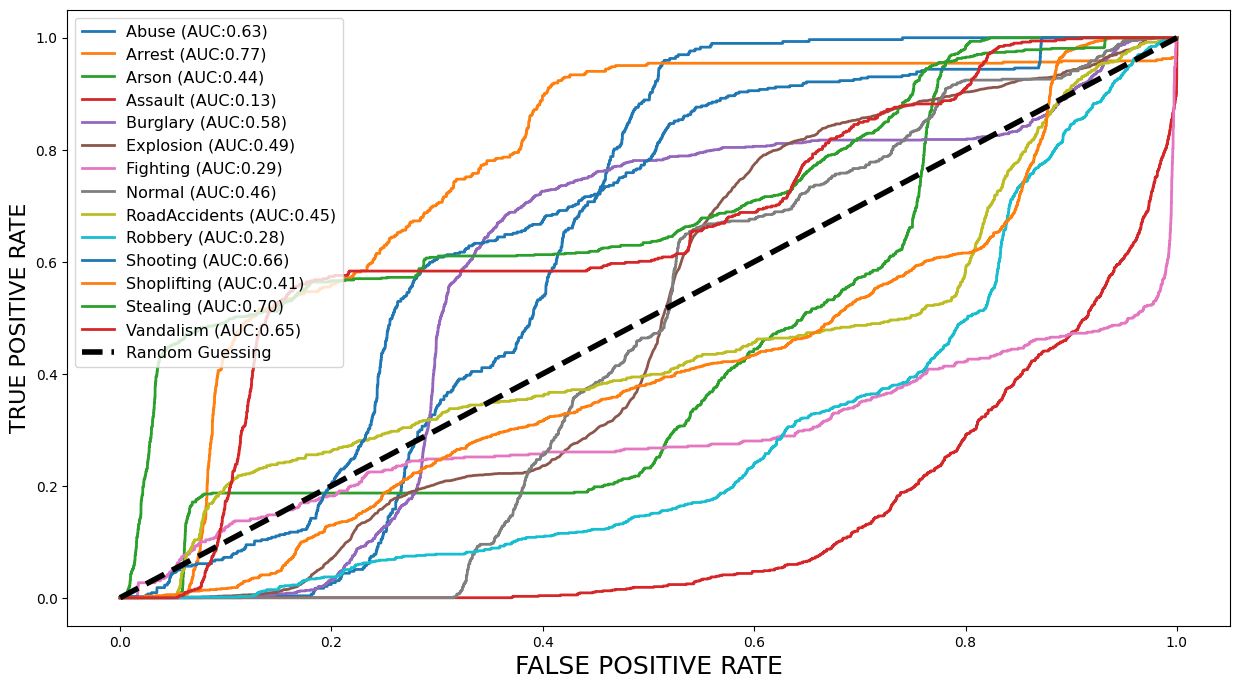

In [ ]:
# Make predictions on the test set
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

# Calculate ROC AUC score
def multiclass_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    roc_auc = roc_auc_score(y_test, y_pred, average='macro')
    return roc_auc

roc_auc = multiclass_roc_auc_score(y_test, preds)
print('ROC AUC score:', roc_auc)
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

# 4. **MobileNetV2**

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Build your own classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

140/140 [==============================] - 77s 220ms/step - loss: 1.6327 - accuracy: 0.5177 - val_loss: 5.7823 - val_accuracy: 0.1008


172/172 [==============================] - 8s 42ms/step
ROC AUC score: 0.5382783438824217


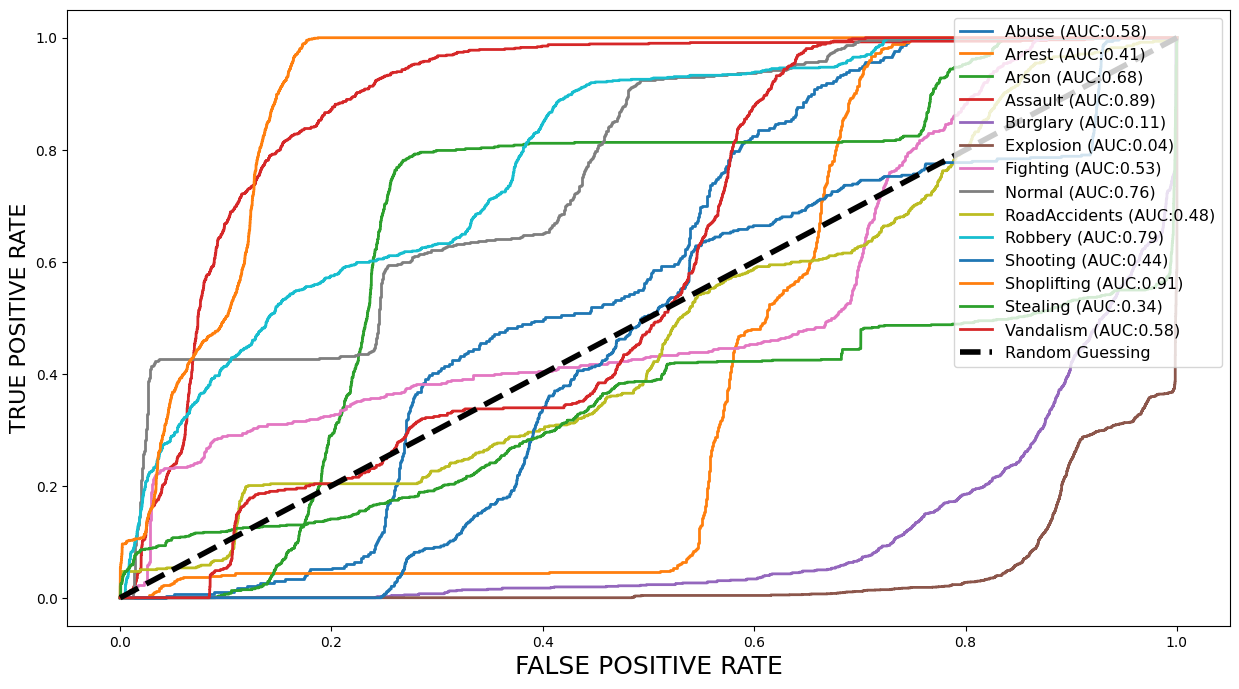

In [ ]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

# Calculate ROC AUC score
def multiclass_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    roc_auc = roc_auc_score(y_test, y_pred, average='macro')
    return roc_auc

roc_auc = multiclass_roc_auc_score(y_test, preds)
print('ROC AUC score:', roc_auc)
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

# 5. **LSTM Model**

In [ ]:
model = tf.keras.Sequential([
    LSTM(256, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)),
    Dropout(0.3),
    LSTM(128),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

ValueError: ignored